In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import product
import numpy as np

from ot.plot import plot1D_mat

In [2]:
def plot(a, b, P):
    plt.figure(3, figsize=(5, 5))
    plot1D_mat(
        a, b, P)

In [3]:
def gauss(m, s, N=500):
    x = np.arange(N, dtype=np.float64)
    h = np.exp(-(x-m)**2 / (2*s**2))
    return h/h.sum()

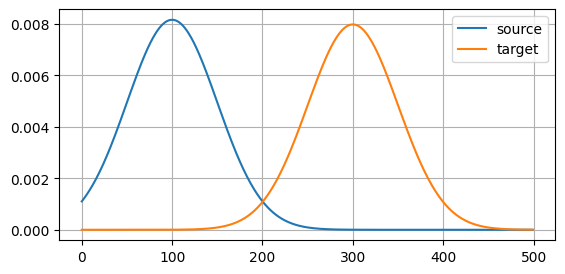

In [4]:
N, h = 500, 1
x = np.arange(0, N, h)
u = gauss(100, 50, N)
v = gauss(300, 50, N)

C = np.array([
    abs(i-j) for i,j in product(range(N), repeat=2)
]).reshape(N,N)

plt.figure(1, figsize=(6.4, 3))
plt.plot(u, label="source")
plt.plot(v, label="target")
plt.legend()
plt.grid(True)
plt.show()

   0| norm(vhat,v)  2.493246| cosine 0.034095
  10| norm(vhat,v) 12.108294| cosine 0.824659
  20| norm(vhat,v) 13.026760| cosine 0.952964
  30| norm(vhat,v) 13.221365| cosine 0.973830
  40| norm(vhat,v) 13.292382| cosine 0.979150
  50| norm(vhat,v) 13.318844| cosine 0.980810
  60| norm(vhat,v) 13.328381| cosine 0.981368
  70| norm(vhat,v) 13.331757| cosine 0.981561
  80| norm(vhat,v) 13.332943| cosine 0.981628
  90| norm(vhat,v) 13.333359| cosine 0.981651
 100| norm(vhat,v) 13.333504| cosine 0.981659
 110| norm(vhat,v) 13.333555| cosine 0.981662
 120| norm(vhat,v) 13.333572| cosine 0.981663
 130| norm(vhat,v) 13.333579| cosine 0.981664
 140| norm(vhat,v) 13.333581| cosine 0.981664
 150| norm(vhat,v) 13.333582| cosine 0.981664
 160| norm(vhat,v) 13.333582| cosine 0.981664
 170| norm(vhat,v) 13.333582| cosine 0.981664
 180| norm(vhat,v) 13.333582| cosine 0.981664
 190| norm(vhat,v) 13.333582| cosine 0.981664
 200| norm(vhat,v) 13.333582| cosine 0.981664


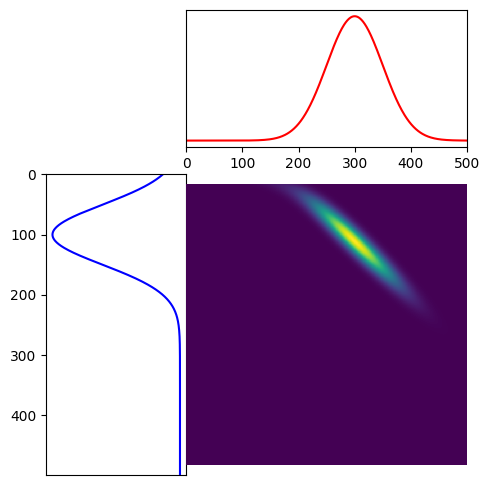

In [5]:
def sinkhorn(u, v, niter=1000, eps=1e-3, mode="naive"):
    
    u = u/u.max().astype(np.float64)
    v = v/v.max().astype(np.float64)
    
    n, m = len(u), len(v)
    psi = np.full((m,1), 1/m)
    
    P = np.zeros(shape=(n,m))
    
    r, s = np.zeros(shape=(n,1)), np.zeros(shape=(n,1))
    p, q = np.zeros(shape=(m,1)), np.zeros(shape=(m,1))
    error = 1e-20
    
    def _cost(n, m):
        return np.array([
            abs(i-j)**2
            for i, j in product(range(n), range(m))
        ]).reshape((n,m))
    
    def _cosine(u, v, eps=1e-8):
        uu = np.einsum("ij,ij->", u, u, optimize=True)
        vv = np.einsum("ij,ij->", v, v, optimize=True)
        uv = np.einsum("ij,ij->", u, v, optimize=True)
        
        deno = np.sqrt(uu) * np.sqrt(vv)
        return 1 - (uv / deno)
    
    def _norm(u):
        return np.sqrt(np.sum(np.square(u)))
    
    C = _cost(n, m)
    C = C/C.max().astype(np.float64)
    
    lmb = np.exp(-1/eps)
    K = lmb ** C
    
    t = 0
    while True:
        if mode == "naive":
            phi = u / np.dot(K, psi)
            psi = v / np.dot(K.T, phi)

        elif mode == "horner":
            p[0] = psi[0]
            q[m-1] = 0.
            for i in range(1, m):
                p[i] = lmb * p[i-1] + psi[i]
                q[m-i-1] = lmb * (q[m-i] + psi[m-i])
            pq = p+q
            phi = u / np.where(pq < error, pq, error)
            
            r[0] = phi[0]
            s[n-1] = 0.
            for i in range(1, n):
                r[i] = lmb * r[i-1] + phi[i]
                s[n-i-1] = lmb * (s[n-i] + phi[n-i])
            rs = r+s
            psi = v / np.where(rs < 0., rs, error)

        P = np.einsum("i,ij,j->ij", phi.reshape(-1), K, psi.reshape(-1), optimize=True)
        
        W = np.linalg.norm(
            np.dot(np.dot((K*C).T, phi).T, psi),
            ord="fro"
        )
        
        vhat = np.einsum("ij->i", P, optimize=True).reshape((-1,1))

        cs = _cosine(vhat, v)
        cond = _norm(vhat-v)
        if t > niter:
            break
        if not t%10: print(f"{t:>4}| norm(vhat,v) {cond:9.6f}| cosine {cs:4.6f}")
        t += 1 

    return P
    

Pn = sinkhorn(
    u.reshape((-1,1)), v.reshape((-1,1)), niter=200, eps=2e-3, mode="naive")
plot(u, v, Pn)
plt.show()

# import ot
# lambd = 2e-3
# M = ot.dist(x.reshape((-1,1)), x.reshape((-1,1)))
# M = M / M.max()
# Gs = ot.sinkhorn(u, v, M, lambd, niter=10, verbose=True)
# plot(u, v, Gs)
# plt.show()

# TODO: Log-domain stabilisation.

In [6]:
def horner(poly, x0):
    out, n = poly[0], len(poly)
    for i in range(1,n):
        out = x0*out + poly[i]
    return out

def estrin(poly, x0):
    pass

horner([2, 3, -4, 1], 8)

1185